In [1]:
import qe.myqengine as qe
import pandas as pd
import numpy as np

In [2]:
univ = qe.ScreenUniverse('FG_CONSTITUENTS(OEX,0,CLOSE)=1')
time_series = qe.TimeSeries(start_date='0Y-10AY',end_date = '0Y',frequency='M')

req = qe.calculate(universe = univ, dates = time_series,formulas = ["FE_BROKER_ESTIMATE(SNAP,EPS,BKR_NAME,QTR_ROLL,+1,#DATE,,',AWIN=1D,ESTDATE=INPUT,WIN=31,')",
                                            "FE_BROKER_ESTIMATE(SNAP,EPS,AN_NAME,QTR_ROLL,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT,')",
                                           "FE_BROKER_ESTIMATE(SNAP,EPS,EST_VALUE,QTR_ROLL,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT')",
                                           "FE_BROKER_ESTIMATE(SNAP,EPS,PREV_VALUE,QTR_ROLL,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT')",
                                        "FE_BROKER_ESTIMATE_DATE(SNAP,EPS,INPUTDATETIME,QTR_ROLL,+1,'YYYYMMDD',#DATE,,'AWIN=1D,ESTDATE=INPUT,WIN=31')",
                                        "FE_BROKER_ESTIMATE(SNAP,EPS,AN_ENTITY_ID,QTR_ROLL,+1,#DATE,,',AWIN=1D,ESTDATE=INPUT,WIN=31,')",
                                        "FE_ESTIMATE_DATE(RPT_DATE,,QTR_ROLL,+1,'YYYYMMDD',#DATE,,,'')",
                                        "FE_SURPRISE(PERCENT,EPS,MEAN,QTR_ROLL,0,#DATE,,,'')",
                                        "P_PRICE_RETURNS(1,20121231,#DATE,RANGE,USD)"],
                                        source = 'FqlExpression',
                                        is_array_return_type=True)


In [51]:

df = req.data.rename(columns={'UNIVERSE':"Ticker"}).set_index("Ticker")
df= df.rename(columns = {"FE_BROKER_ESTIMATE(SNAP,EPS,BKR_NAME,QTR_ROLL,+1,#DATE,,',AWIN=1D,ESTDATE=INPUT,WIN=31,')":"Broker Name",
                     "FE_BROKER_ESTIMATE(SNAP,EPS,AN_NAME,QTR_ROLL,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT,')":'Analyst Name',
                    "FE_BROKER_ESTIMATE(SNAP,EPS,EST_VALUE,QTR_ROLL,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT')":"EST_EPS_FY1",
                    "FE_BROKER_ESTIMATE(SNAP,EPS,PREV_VALUE,QTR_ROLL,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT')":"PREV_EST_EPS_FY1",
                    "FE_BROKER_ESTIMATE_DATE(SNAP,EPS,INPUTDATETIME,QTR_ROLL,+1,'YYYYMMDD',#DATE,,'AWIN=1D,ESTDATE=INPUT,WIN=31')":'Research Date',
                    "FE_BROKER_ESTIMATE(SNAP,EPS,AN_ENTITY_ID,QTR_ROLL,+1,#DATE,,',AWIN=1D,ESTDATE=INPUT,WIN=31,')":"Analyst ID",
                    "P_PRICE_RETURNS(1,20121231,#DATE,RANGE,USD)":"Cumulative Return",
                    "FE_ESTIMATE_DATE(RPT_DATE,,QTR_ROLL,+1,'YYYYMMDD',#DATE,,,'')":'Report Date',
                    "FE_SURPRISE(PERCENT,EPS,MEAN,QTR_ROLL,0,#DATE,,,'')":"Surprise",
                    "DATE":'Date'
                    })



In [52]:
df['Date'] = df['Date'].replace('@NA',np.nan)
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date']).apply(lambda x:x.strftime("%m/%d/%Y"))
df['Report Date']= pd.to_datetime(df['Report Date'].apply(lambda x: x[0]))
df_e = pd.concat([df['Analyst ID'].explode().reset_index()[['Ticker','Analyst ID']],df['Broker Name'].explode().reset_index().iloc[:,-1:],df['Analyst Name'].explode().reset_index().iloc[:,-1:],df['EST_EPS_FY1'].explode().reset_index().iloc[:,-1:],df['PREV_EST_EPS_FY1'].explode().reset_index().iloc[:,-1:],df['Research Date'].explode().reset_index().iloc[:,-1:]],axis=1)
df_e['Research Date'] = df_e['Research Date'].replace('@NA',np.nan)
df_e = df_e.dropna()
df_e['Research Date'] = pd.to_datetime(df_e['Research Date'])
df_e = df_e.replace('Restricted',np.nan).replace('@NA',np.nan)
df_e = df_e.groupby(['Research Date','Broker Name','Ticker']).agg({'EST_EPS_FY1':'mean'})
df_e.head()

EST_EPS_FY1
Research Date Broker Name             Ticker             
2012-07-08    Societe Generale        ORCL          0.630
2012-07-24    Wells Fargo Securities  SPG           0.910
2012-07-27    Cowen & Company         AMZN          0.008
              Janney Montgomery Scott CL            0.665
2012-08-13    Deutsche Bank Research  GILD          0.495

In [53]:
df_e = pd.DataFrame(df_e['EST_EPS_FY1'].unstack().unstack().ffill(limit = 90).stack().stack()).rename(columns = {0:'EST_EPS_FY1'})
df_stat = df_e.reset_index().groupby(['Research Date', 'Ticker']).agg({'EST_EPS_FY1': [np.mean, np.median, np.std]})
df_stat = df_stat.reset_index().rename(columns = {'Research Date':'Date',
                                        }).set_index(['Date','Ticker'])
df  =df.reset_index().set_index(['Date','Ticker'])
df_full = df.iloc[:,7:].join(df_stat,how='left')
df_full['Surprise'] = df_full['Surprise'].apply(lambda x: x[0])
df_full['Cumulative Return'] = df_full['Cumulative Return'].apply(lambda x: x[0])

C:\Users\nurciuoli\AppData\Local\Temp\2\ipykernel_3612\3352229707.py:6: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_full = df.iloc[:,7:].join(df_stat,how='left')


In [54]:
df_full['Period Return'] = df_full['Cumulative Return'].pct_change()

<Axes: xlabel='Date', ylabel="('EST_EPS_FY1', 'mean')">

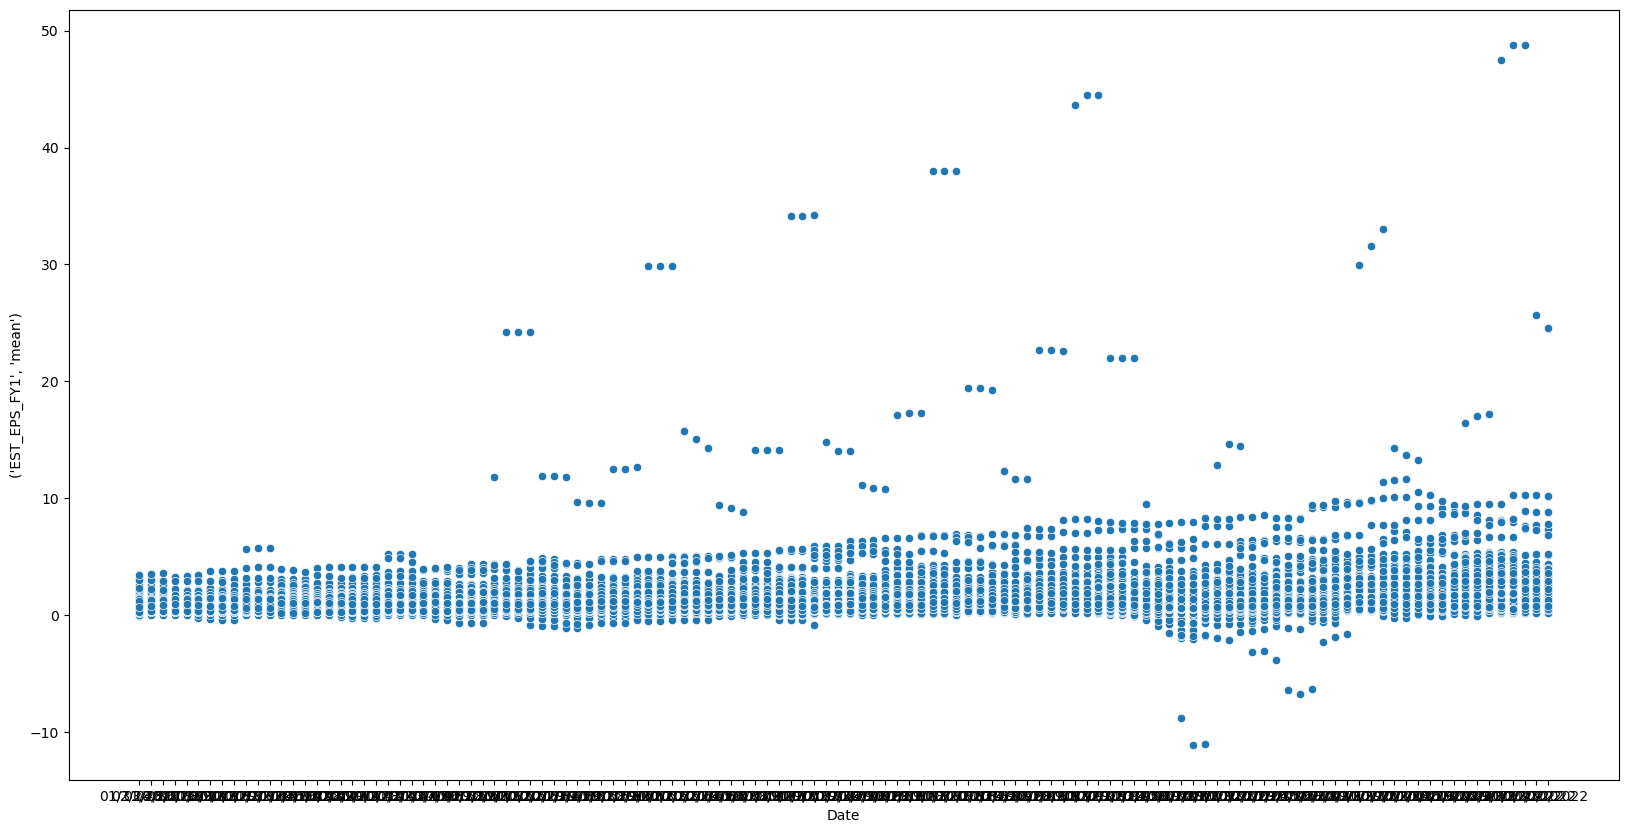

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (20,10))
df_plot = df_full.dropna().reset_index()
sns.scatterplot(df_plot.reset_index(),x = 'Date',y = ('EST_EPS_FY1', 'mean'))

c:\Users\nurciuoli\AppData\Local\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel="('EST_EPS_FY1', 'mean')", ylabel='log period returns'>

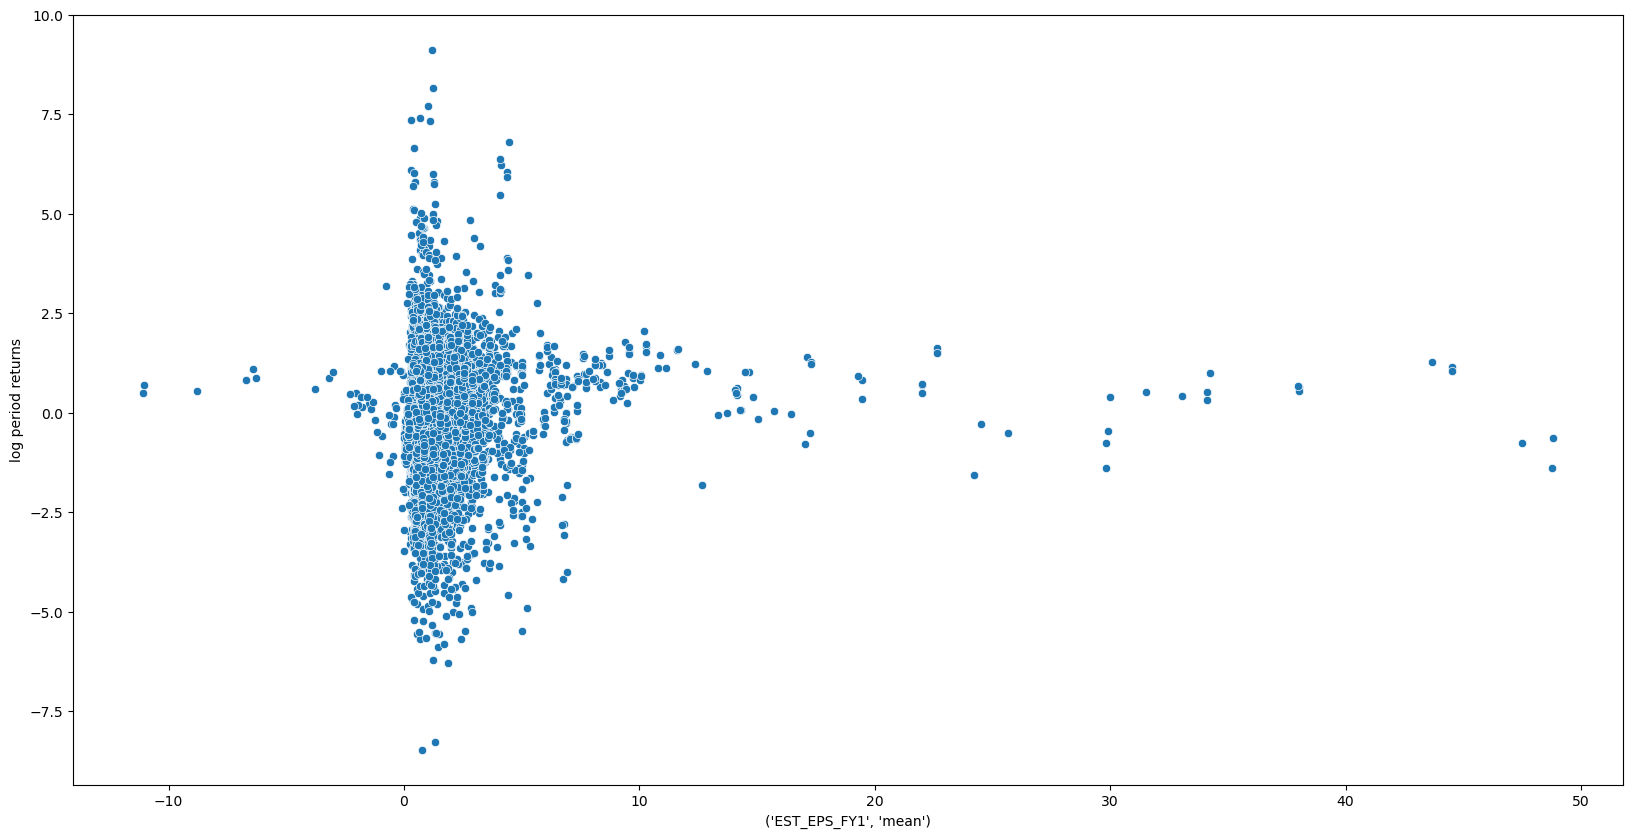

In [71]:
fig,ax = plt.subplots(figsize = (20,10))
df_plot['log period returns']= np.log(df_plot['Period Return'])
sns.scatterplot(df_plot,x = ('EST_EPS_FY1', 'mean'),y = "log period returns",)

<Axes: xlabel="('EST_EPS_FY1', 'std')", ylabel='log period returns'>

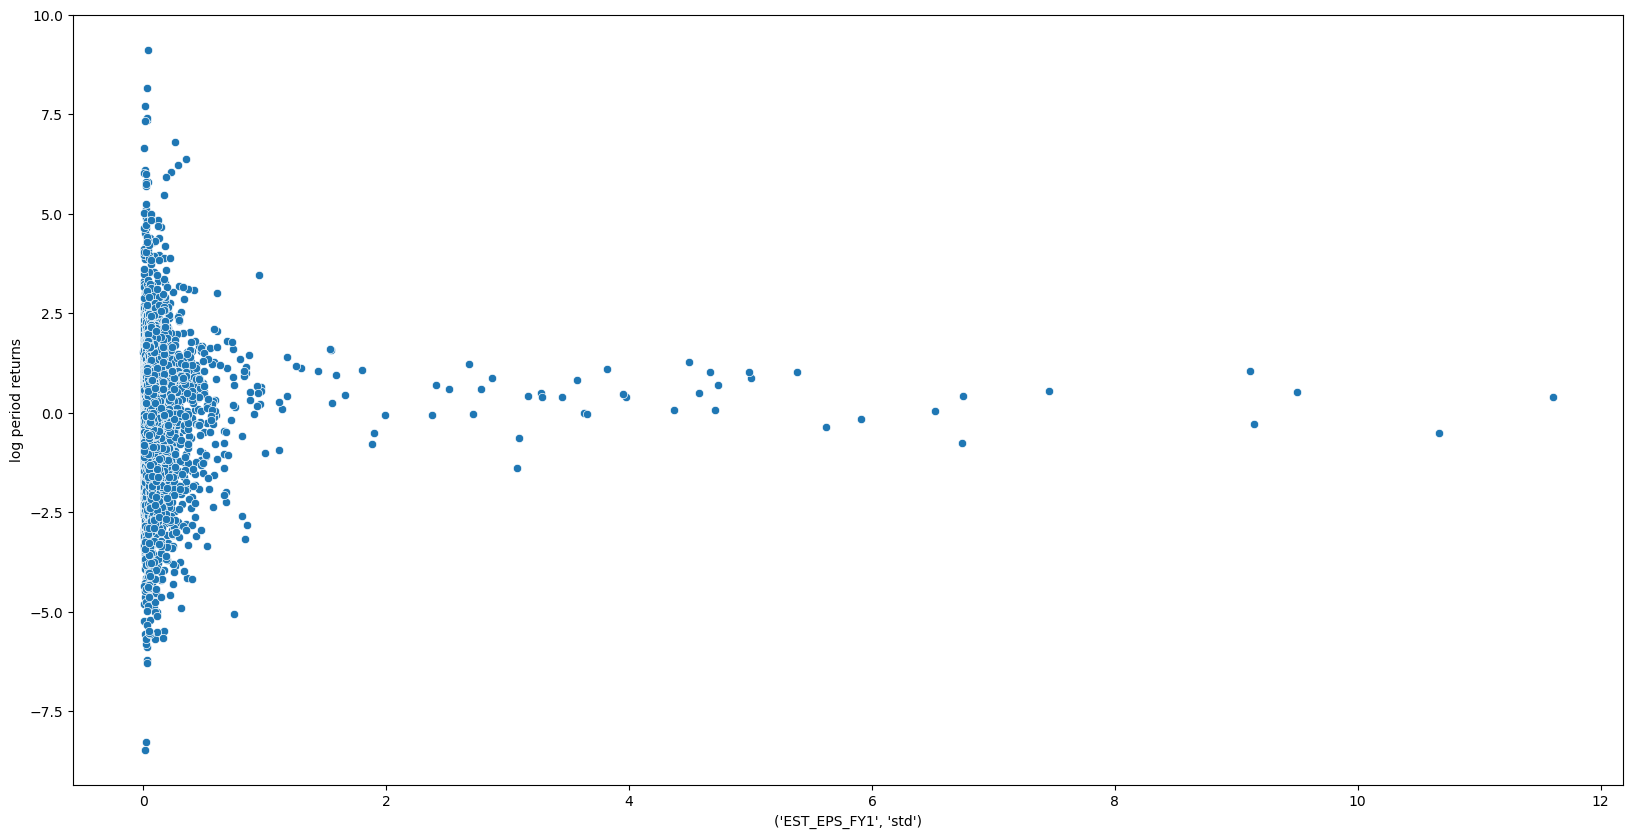

In [70]:
fig,ax = plt.subplots(figsize = (20,10))
sns.scatterplot(df_plot,x = ('EST_EPS_FY1', 'std'),y = "log period returns",)

<Axes: xlabel="('EST_EPS_FY1', 'median')", ylabel='log period returns'>

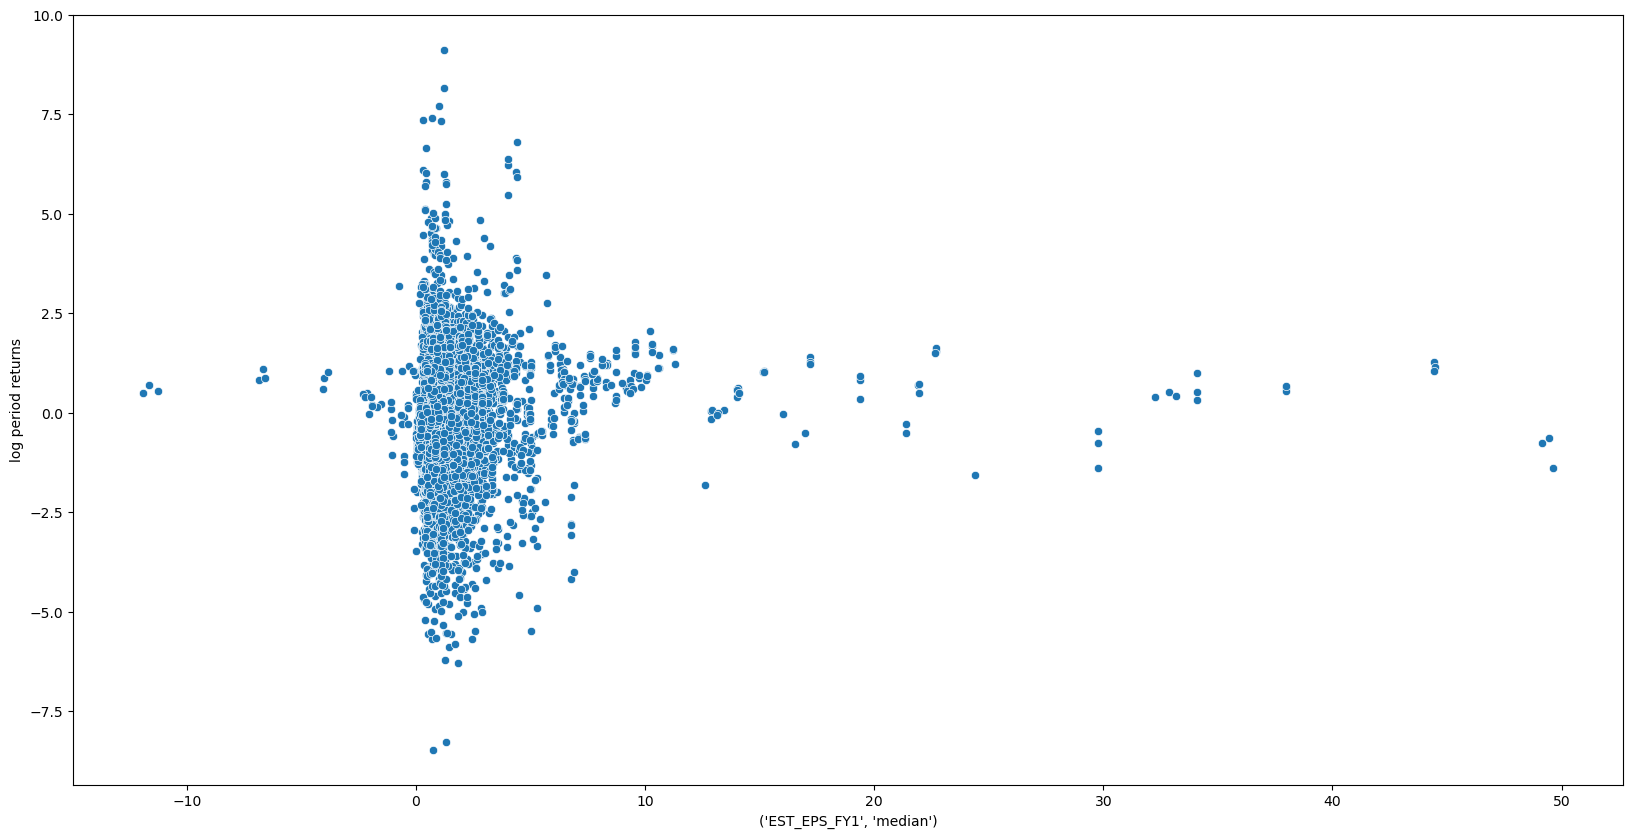

In [69]:
fig,ax = plt.subplots(figsize = (20,10))
sns.scatterplot(df_plot,x = ('EST_EPS_FY1', 'median'),y = "log period returns",)

In [60]:
df_plot = df_plot.set_index(['Date','Ticker']).join(df_plot.set_index(['Date','Ticker'])['Period Return'].unstack().shift(-12).stack().rename('lag 12 ret'),how='left').reset_index()

In [62]:
df_plot['lag 12 ret']= np.log(df_plot['lag 12 ret'])

c:\Users\nurciuoli\AppData\Local\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel="('EST_EPS_FY1', 'std')", ylabel='lag 12 ret'>

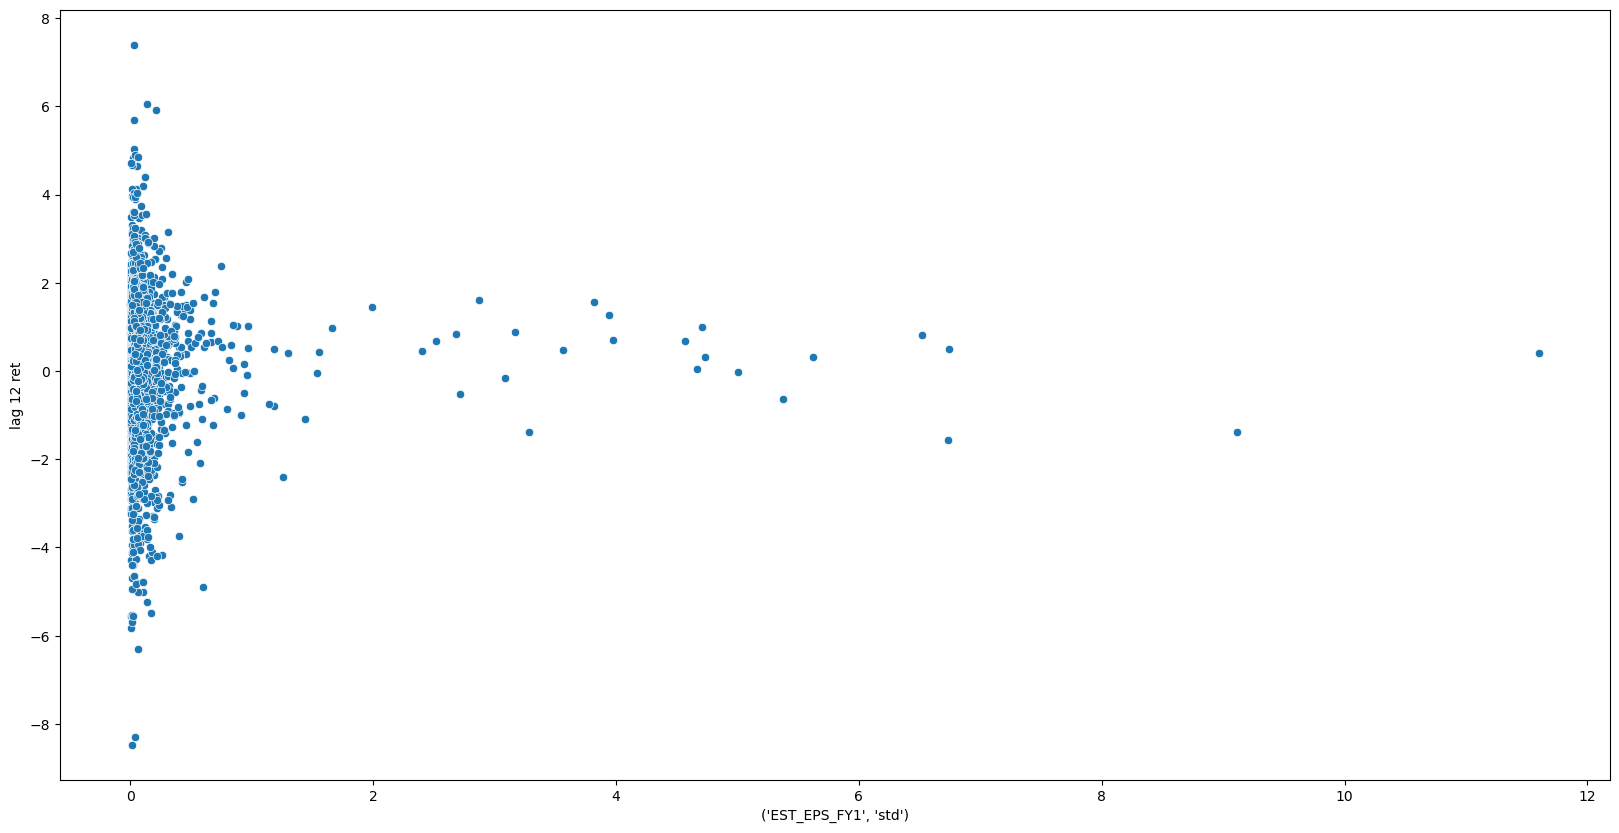

In [68]:
fig,ax = plt.subplots(figsize = (20,10))
sns.scatterplot(df_plot.dropna(),x = ('EST_EPS_FY1', 'std'),y = "lag 12 ret",)

<Axes: xlabel="('EST_EPS_FY1', 'mean')", ylabel='lag 12 ret'>

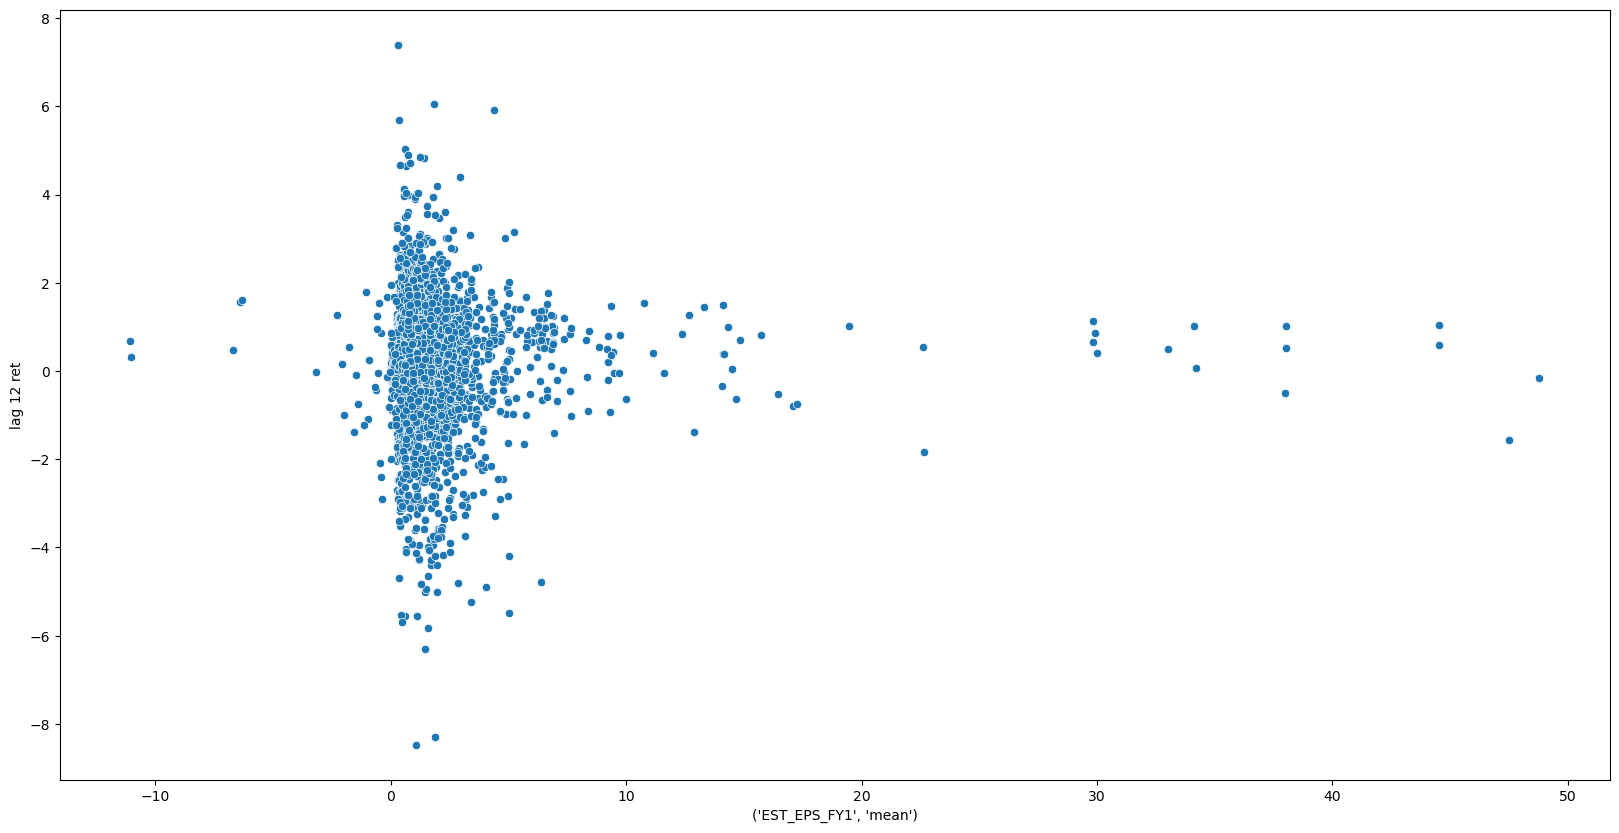

In [67]:
fig,ax = plt.subplots(figsize = (20,10))
sns.scatterplot(df_plot.dropna(),x = ('EST_EPS_FY1', 'mean'),y = "lag 12 ret",)

In [75]:
df_full.to_pickle('../../data/Backtesting/estimates_broker_detail_2012_2022_oex.pkl')